# Prueba de simulación de horseshoe

Aquí simularemos un prior horseshoe, donde 5 parámetros serán significativamente distintos de 0, mientras que otros 45 rondarán valores cercanos a 0. Esto nos permitirá ver el uso de este prior en particular. 



In [2]:
import arviz as az
import numpy as np
import pymc as pm
import pandas as pd
import matplotlib.pyplot as plt



D = 50  # Cantidad de predictores
D0 = 5  # Cantidad de predictores cuyo 'beta' es distinto de 0

# Armamos el generador (para que los resultados sean reproducibles)
SEED = 12345
rng = np.random.default_rng(SEED)

INTERCEPT = rng.uniform(-3, 3)

BETAS = np.zeros(D)
BETAS[:D0] = rng.choice([-1, 1], size=D0) * rng.normal(5, 1, size=D0)

N = 100

X = rng.normal(size=(N, D))

SIGMA = 1.

mu = INTERCEPT + np.dot(X, BETAS) 
y = rng.normal(mu, SIGMA, size=N)

X.shape, mu.shape, y.shape


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


((100, 50), (100,), (100,))

Aquí lo que hicimos fue lo siguiente: 

* Definimos un intercepto
* Definimos un vector de 50 betas, de los cuales 5 toman valores de una normal(5,1) y luego se le asigna un "signo" al azar
* Se crea la matriz de diseño, con normales(0,1), y se fija sigma en 1
* Se calculan las medias determinísticas mu con el intercepto y la matriz de diseño por los betas
* Se simulan variables respuesta con normales(mu, sigma)

Luego se procede a la estimación bayesiana del modelo. Se propone como prior el horseshoe, para el cual se calculan los siguientes parámetros: 

$$\mu_i = \alpha + \beta_1 x_{1i} + \beta_2 x_{2i} + ... + \beta_p x_{pi}$$

$$y_i \sim N(\mu_i, \sigma^2)$$

$$\alpha \sim N(0,1)$$

$$\beta_j \sim N(0,\lambda_j^2 \tau^2)$$

$$\lambda_j \sim C^+(0,1)$$

$$\tau \sim T^+(df=3)$$

$$\sigma^2 \sim N^+(0,1)$$

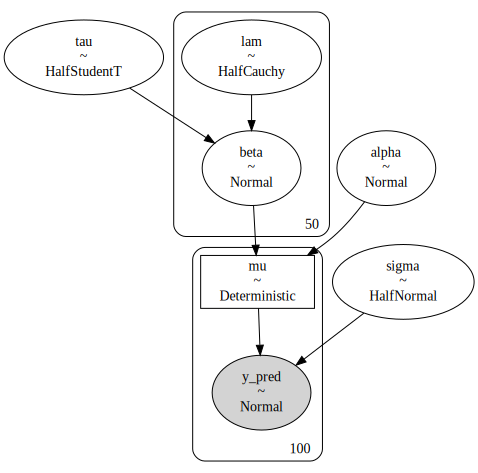

In [3]:
with pm.Model() as modelo:
    alpha = pm.Normal('alpha', mu=0, sigma=1) # escalar
    tau = pm.HalfStudentT("tau", nu=3)        # escalar 
    lam = pm.HalfCauchy("lam", beta=1, shape=D)       # vector longitud D
    beta = pm.Normal('beta', mu=0, sigma=lam*tau, shape=D)  # vector longitud D
    sigma = pm.HalfNormal('sigma') # escalar
    mu = pm.Deterministic('mu', alpha + X@beta)
    y_pred = pm.Normal('y_pred', mu=mu, sigma=sigma, observed=y)

pm.model_to_graphviz(modelo)

In [ ]:
with modelo:
    idata = pm.sample(random_seed=123, target_accept=0.95)

In [ ]:
pd.set_option('display.max_rows', None)
az.summary(idata)

summary_df = az.summary(idata)
print(summary_df)

print(INTERCEPT)

In [ ]:
with modelo:
    prior_predictive = pm.sample_prior_predictive(samples=1000)

az.plot_dist(prior_predictive.prior.beta, label='beta_0')
az.plot_dist(prior_predictive.prior.alpha, label='alpha')
az.plot_dist(prior_predictive.prior.lam, label='lam')

plt.xlabel('Valor de beta')
plt.ylabel('Densidad')
plt.title('Distribuciones a priori de los betas')
plt.legend()
plt.show()


## Ejemplo 2

Probemos usar distinta cantidad de valores para estos parámetros.

In [ ]:
D = 20  # Cantidad de predictores
D0 = 10  # Cantidad de predictores cuyo 'beta' es distinto de 0

# Armamos el generador (para que los resultados sean reproducibles)
SEED = 2398
rng = np.random.default_rng(SEED)

INTERCEPT = rng.uniform(-2, 2)

BETAS = np.zeros(D)
BETAS[:D0] = rng.choice([-1, 1], size=D0) * rng.normal(5, 1, size=D0)

N = 100

X = rng.normal(size=(N, D))

SIGMA = 1.

mu = INTERCEPT + np.dot(X, BETAS) 
y = rng.normal(mu, SIGMA, size=N)

X.shape, mu.shape, y.shape

In [ ]:
# Por ahora no cambiamos nada del modelo

with pm.Model() as modelo:
    alpha = pm.Normal('alpha', mu=0, sigma=1) # escalar
    tau = pm.HalfStudentT("tau", nu=3)        # escalar 
    lam = pm.HalfCauchy("lam", beta=1, shape=D)       # vector longitud D
    beta = pm.Normal('beta', mu=0, sigma=lam*tau, shape=D)  # vector longitud D
    sigma = pm.HalfNormal('sigma') # escalar
    mu = pm.Deterministic('mu', alpha + X@beta)
    y_pred = pm.Normal('y_pred', mu=mu, sigma=sigma, observed=y)

pm.model_to_graphviz(modelo)

In [ ]:
with modelo:
    idata = pm.sample(random_seed=1234, target_accept=0.95) 

In [ ]:
az.summary(idata)



En este caso también logró identificar bien a los parámetros significativos, sin embargo quedó uno de los valores 0 con el intervalo todo por debajo de 0, esto sería que lo está dando, aunque sea por poco, significativo. Ahora probaremos acercando un poco más los valores de los betas a 0, a ver qué tanto logran escaparse de este valor. Además aumentaremos un poco más la variabilidad de los datos. 

(Agregar forest plot)

In [ ]:
D = 20  # Cantidad de predictores
D0 = 10  # Cantidad de predictores cuyo 'beta' es distinto de 0

# Armamos el generador (para que los resultados sean reproducibles)
SEED = 3648795
rng = np.random.default_rng(SEED)

INTERCEPT = rng.uniform(-2, 2)

BETAS = np.zeros(D)
BETAS[:D0] = rng.choice([-1, 1], size=D0) * rng.normal(2, 1, size=D0)

N = 100

X = rng.normal(size=(N, D)) # A mayor desvío acá, mayor desvío de las estimaciones (betas)

SIGMA = 3

mu = INTERCEPT + np.dot(X, BETAS) 
y = rng.normal(mu, SIGMA, size=N)

X.shape, mu.shape, y.shape

In [ ]:
with pm.Model() as modelo:
    alpha = pm.Normal('alpha', mu=0, sigma=1) # escalar
    tau = pm.HalfStudentT("tau", nu=3)        # escalar 
    lam = pm.HalfCauchy("lam", beta=1, shape=D)       # vector longitud D
    beta = pm.Normal('beta', mu=0, sigma=lam*tau, shape=D)  # vector longitud D
    sigma = pm.HalfNormal('sigma') # escalar
    mu = pm.Deterministic('mu', alpha + X@beta)
    y_pred = pm.Normal('y_pred', mu=mu, sigma=sigma, observed=y)

with modelo:
    idata = pm.sample(random_seed=167823) 

In [ ]:
pd.set_option('display.max_rows', None)

az.summary(idata)
# az.plot_trace(idata)
#az.plot_forest(idata, var_names=['beta'], combined=True)



## Ejemplo 3

Vamos a cambiar algunos parámetros de las distribuciones de los hiperparámetros para ver como se comportan, bajo la misma configuración del modelo. 
(subir grados de libertad acerca mas a una dist normal (colas menos pesadas))

In [ ]:
with pm.Model() as modelo:
    alpha = pm.Normal('alpha', mu=0, sigma=1) # escalar
    tau = pm.HalfStudentT("tau", nu=10)        # escalar 
    lam = pm.HalfCauchy("lam", beta=1, shape=D)       # vector longitud D
    beta = pm.Normal('beta', mu=0, sigma=lam*tau, shape=D)  # vector longitud D
    sigma = pm.HalfNormal('sigma') # escalar
    mu = pm.Deterministic('mu', alpha + X@beta)
    y_pred = pm.Normal('y_pred', mu=mu, sigma=sigma, observed=y)

with modelo:
    idata = pm.sample(random_seed=13234, target_accept=0.95) 

az.summary(idata, var_names=["beta", "sigma", "lam"])

In [ ]:
az.plot_forest(idata, var_names=['beta'], combined=True)


# Ejemplo 4

Vamos a achicar el tamaño de muestra, para ver como se comporta el prior con un N menor.

## Tamaño de muestra 50

In [ ]:
D = 20  # Cantidad de predictores
D0 = 10  # Cantidad de predictores cuyo 'beta' es distinto de 0

# Armamos el generador (para que los resultados sean reproducibles)
SEED = 3648795
rng = np.random.default_rng(SEED)

INTERCEPT = rng.uniform(-2, 2)

BETAS = np.zeros(D)
BETAS[:D0] = rng.choice([-1, 1], size=D0) * rng.normal(2, 1, size=D0)

N = 50

X = rng.normal(size=(N, D)) # A mayor desvío acá, mayor desvío de las estimaciones (betas)

SIGMA = 3

mu = INTERCEPT + np.dot(X, BETAS) 
y = rng.normal(mu, SIGMA, size=N)

In [ ]:
with pm.Model() as modelo:
    alpha = pm.Normal('alpha', mu=0, sigma=1) # escalar
    tau = pm.HalfStudentT("tau", nu=3)        # escalar 
    lam = pm.HalfCauchy("lam", beta=1, shape=D)       # vector longitud D
    beta = pm.Normal('beta', mu=0, sigma=lam*tau, shape=D)  # vector longitud D
    sigma = pm.HalfNormal('sigma') # escalar
    mu = pm.Deterministic('mu', alpha + X@beta)
    y_pred = pm.Normal('y_pred', mu=mu, sigma=sigma, observed=y)

with modelo:
    idata = pm.sample(random_seed=167823) 

In [ ]:
ax, = az.plot_forest(
    idata, var_names=["beta"], coords={"beta_dim_0": range(D)},
    kind='ridgeplot', ridgeplot_truncate=False, ridgeplot_alpha=0.5,
    hdi_prob=0.95, combined=True,
    figsize=(8, 6)
)
ax.scatter(BETAS[:D][::-1], ax.get_yticks(),
           c='C1',
           label="Actual value");

ax.set_xlabel(r"$\beta_i$");

ax.set_ylim(bottom=None, top=1.2 * ax.get_yticks().max())
ax.set_yticklabels(range(D)[::-1]);
ax.set_ylabel(r"$i$");

ax.legend(loc='upper center');
ax.set_title("Posterior distribution of nonzero coefficients");

## Tamaño de muestra 30

In [ ]:
D = 20  # Cantidad de predictores
D0 = 10  # Cantidad de predictores cuyo 'beta' es distinto de 0

# Armamos el generador (para que los resultados sean reproducibles)
SEED = 3648795
rng = np.random.default_rng(SEED)

INTERCEPT = rng.uniform(-2, 2)

BETAS = np.zeros(D)
BETAS[:D0] = rng.choice([-1, 1], size=D0) * rng.normal(2, 1, size=D0)

N = 50

X = rng.normal(size=(N, D)) # A mayor desvío acá, mayor desvío de las estimaciones (betas)

SIGMA = 3

mu = INTERCEPT + np.dot(X, BETAS) 
y = rng.normal(mu, SIGMA, size=N)

with pm.Model() as modelo:
    alpha = pm.Normal('alpha', mu=0, sigma=1) # escalar
    tau = pm.HalfStudentT("tau", nu=3)        # escalar 
    lam = pm.HalfCauchy("lam", beta=1, shape=D)       # vector longitud D
    beta = pm.Normal('beta', mu=0, sigma=lam*tau, shape=D)  # vector longitud D
    sigma = pm.HalfNormal('sigma') # escalar
    mu = pm.Deterministic('mu', alpha + X@beta)
    y_pred = pm.Normal('y_pred', mu=mu, sigma=sigma, observed=y)

with modelo:
    idata = pm.sample(random_seed=167823, target_accept=0.95) 

In [ ]:
ax, = az.plot_forest(
    idata, var_names=["beta"], coords={"beta_dim_0": range(D)},
    kind='ridgeplot', ridgeplot_truncate=False, ridgeplot_alpha=0.5,
    hdi_prob=0.95, combined=True,
    figsize=(8, 6)
)
ax.scatter(BETAS[:D][::-1], ax.get_yticks(),
           c='C1',
           label="Actual value");

ax.set_xlabel(r"$\beta_i$");

ax.set_ylim(bottom=None, top=1.2 * ax.get_yticks().max())
ax.set_yticklabels(range(D)[::-1]);
ax.set_ylabel(r"$i$");

ax.legend(loc='upper center');
ax.set_title("Posterior distribution of nonzero coefficients");

# Regularized horseshoe prior

Planteamos un modelo para utilizar el prior denominado como Regularized Horseshoe. Es similar al anterior, solo que cambian la forma de estimar algunos de los parámetros

$$\mu_i = \alpha + \beta_1 x_{1i} + \beta_2 x_{2i} + ... + \beta_p x_{pi}$$

$$y_i \sim N(\mu_i, \sigma^2)$$

$$\alpha \sim N(0,10)$$

$$\sigma^2 \sim N^+(0,2.5)$$

$$\beta_j \sim N(0,\tilde{\lambda}_j^2 \cdot \tau^2)$$

$$\tilde{\lambda}_i^2 = \frac{c^2 \lambda_i^2}{c^2 + \tau^2 \lambda_i^2}$$

(dado que se estima que hay efectivamente $D_0$ coeficientes distintos de 0)

$$\tau \sim T^+_2 ( \frac{D_0}{D-D_0} \cdot \frac{\sigma} {\sqrt{N}} )$$ 

$$\lambda_i \sim T^+_5(1)$$

$$c^2 \sim \textrm{GammaInv}(1, 1)$$



In [ ]:
D = 50  # Cantidad de predictores
D0 = 5  # Cantidad de predictores cuyo 'beta' es distinto de 0

# Armamos el generador (para que los resultados sean reproducibles)
SEED = 12347565
rng = np.random.default_rng(SEED)

INTERCEPT = rng.uniform(-3, 3)

BETAS = np.zeros(D)
BETAS[:D0] = rng.choice([-1, 1], size=D0) * rng.normal(5, 1, size=D0)

N = 100

X = rng.normal(size=(N, D))

SIGMA = 1.

mu = INTERCEPT + np.dot(X, BETAS) 
y = rng.normal(mu, SIGMA, size=N)

X.shape, mu.shape, y.shape


In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=D0,
                         sharex=True, sharey=True,
                         figsize=(16, 6))

for i, (ax, coef) in enumerate(zip(axes[0], BETAS)):
    ax.scatter(X[:, i], y, alpha=0.75);
    
    ax.set_xlabel(f"$x_{{ {i} }}$");
    ax.set_title(f"$\\beta_{{ {i} }} \\approx {coef:.2f}$");


zero_coef_ix = rng.choice(range(D0, D), replace=False, size=D0)
zero_coef_ix.sort()

for ax, i in zip(axes[1], zero_coef_ix):
    ax.scatter(X[:, i], y, alpha=0.75);
    
    ax.set_xlabel(f"$x_{{ {i} }}$");
    ax.set_title(f"$\\beta_{{ {i} }} = 0$");
    
axes[0, 0].set_ylabel("$y$");
axes[1, 0].set_ylabel("$y$");

fig.tight_layout();

In [ ]:
with pm.Model() as modelo:
    sigma = pm.HalfNormal('sigma', 2.5) # escalar
    alpha = pm.Normal('alpha', mu=0, sigma=10) # escalar
    tau = pm.HalfStudentT("tau", 2, D0 / (D - D0) * sigma / np.sqrt(N))  # escalar 
    lam = pm.HalfCauchy("lam", 5, shape=D)       # vector longitud D}
    c2 = pm.InverseGamma("c2", 1, 1) # escalar
    lam_ = pm.Deterministic('lam_', lam * np.sqrt(c2 / (c2 + tau**2 * lam**2))) # vector de longitud D
    beta = pm.Normal('beta', mu=0, sigma=lam_*tau, shape=D)  # vector longitud D
    mu = pm.Deterministic('mu', alpha + X@beta)
    y_pred = pm.Normal('y_pred', mu=mu, sigma=sigma, observed=y)

with modelo:
    idata = pm.sample(random_seed=13234, target_accept=0.95) 

pd.set_option('display.max_rows', None)


In [ ]:
ax, = az.plot_forest(
    idata, var_names=["beta"], coords={"beta_dim_0": range(D0)},
    kind='ridgeplot', ridgeplot_truncate=False, ridgeplot_alpha=0.5,
    hdi_prob=0.95, combined=True,
    figsize=(8, 6)
)
ax.scatter(BETAS[:D0][::-1], ax.get_yticks(),
           c='C1',
           label="Actual value");

ax.set_xlabel(r"$\beta_i$");

ax.set_ylim(bottom=None, top=1.55 * ax.get_yticks().max())
ax.set_yticklabels(range(D0)[::-1]);
ax.set_ylabel(r"$i$");

ax.legend(loc='upper center');
ax.set_title("Posterior distribution of nonzero coefficients");

## Pruebas variando la cantidad de coeficientes 


In [ ]:
D = 20  # Cantidad de predictores
D0 = 10  # Cantidad de predictores cuyo 'beta' es distinto de 0

# Armamos el generador (para que los resultados sean reproducibles)
SEED = 65436978
rng = np.random.default_rng(SEED)

INTERCEPT = rng.uniform(-3, 3)

BETAS = np.zeros(D)
BETAS[:D0] = rng.choice([-1, 1], size=D0) * rng.normal(5, 1, size=D0)

N = 100

X = rng.normal(size=(N, D))

SIGMA = 1.

mu = INTERCEPT + np.dot(X, BETAS) 
y = rng.normal(mu, SIGMA, size=N)

with pm.Model() as modelo:
    sigma = pm.HalfNormal('sigma', 2.5) # escalar
    alpha = pm.Normal('alpha', mu=0, sigma=10) # escalar
    tau = pm.HalfStudentT("tau", 2, D0 / (D - D0) * sigma / np.sqrt(N))  # escalar 
    lam = pm.HalfCauchy("lam", 5, shape=D)       # vector longitud D}
    c2 = pm.InverseGamma("c2", 1, 1) # escalar
    lam_ = pm.Deterministic('lam_', lam * np.sqrt(c2 / (c2 + tau**2 * lam**2))) # vector de longitud D
    beta = pm.Normal('beta', mu=0, sigma=lam_*tau, shape=D)  # vector longitud D
    mu = pm.Deterministic('mu', alpha + X@beta)
    y_pred = pm.Normal('y_pred', mu=mu, sigma=sigma, observed=y)

with modelo:
    idata = pm.sample(random_seed=34256789, target_accept=0.95) 

pd.set_option('display.max_rows', None)
az.summary(idata)

az.summary(idata, var_names=["beta", "sigma", "lam"])

In [ ]:
ax, = az.plot_forest(
    idata, var_names=["beta"], coords={"beta_dim_0": range(D0)},
    kind='ridgeplot', ridgeplot_truncate=False, ridgeplot_alpha=0.5,
    hdi_prob=0.95, combined=True,
    figsize=(8, 6)
)
ax.scatter(BETAS[:D0][::-1], ax.get_yticks(),
           c='C1',
           label="Actual value");

ax.set_xlabel(r"$\beta_i$");

ax.set_ylim(bottom=None, top=1.55 * ax.get_yticks().max())
ax.set_yticklabels(range(D0)[::-1]);
ax.set_ylabel(r"$i$");

ax.legend(loc='upper center');
ax.set_title("Posterior distribution of nonzero coefficients");

## ¿Qué pasa si cambiamos el tamaño de muestra por uno mucho más chico?

### Tamaño de muestra 30

In [ ]:
D = 20  # Cantidad de predictores
D0 = 10  # Cantidad de predictores cuyo 'beta' es distinto de 0

# Armamos el generador (para que los resultados sean reproducibles)
SEED = 65436978
rng = np.random.default_rng(SEED)

INTERCEPT = rng.uniform(-3, 3)

BETAS = np.zeros(D)
BETAS[:D0] = rng.choice([-1, 1], size=D0) * rng.normal(5, 1, size=D0)

N = 30

X = rng.normal(size=(N, D))

SIGMA = 1.

mu = INTERCEPT + np.dot(X, BETAS) 
y = rng.normal(mu, SIGMA, size=N)

with pm.Model() as modelo:
    sigma = pm.HalfNormal('sigma', 2.5) # escalar
    alpha = pm.Normal('alpha', mu=0, sigma=10) # escalar
    tau = pm.HalfStudentT("tau", 2, D0 / (D - D0) * sigma / np.sqrt(N))  # escalar 
    lam = pm.HalfCauchy("lam", 5, shape=D)       # vector longitud D}
    c2 = pm.InverseGamma("c2", 1, 1) # escalar
    lam_ = pm.Deterministic('lam_', lam * np.sqrt(c2 / (c2 + tau**2 * lam**2))) # vector de longitud D
    beta = pm.Normal('beta', mu=0, sigma=lam_*tau, shape=D)  # vector longitud D
    mu = pm.Deterministic('mu', alpha + X@beta)
    y_pred = pm.Normal('y_pred', mu=mu, sigma=sigma, observed=y)

with modelo:
    idata = pm.sample(random_seed=34256789, target_accept=0.95) 

pd.set_option('display.max_rows', None)
az.summary(idata)

az.summary(idata, var_names=["beta", "sigma", "lam"])

In [ ]:
ax, = az.plot_forest(
    idata, var_names=["beta"], coords={"beta_dim_0": range(D)},
    kind='ridgeplot', ridgeplot_truncate=False, ridgeplot_alpha=0.5,
    hdi_prob=0.95, combined=True,
    figsize=(8, 6)
)
ax.scatter(BETAS[:D][::-1], ax.get_yticks(),
           c='C1',
           label="Actual value");

ax.set_xlabel(r"$\beta_i$");

ax.set_ylim(bottom=None, top=1.55 * ax.get_yticks().max())
ax.set_yticklabels(range(D)[::-1]);
ax.set_ylabel(r"$i$");

ax.legend(loc='upper center');
ax.set_title("Posterior distribution of nonzero coefficients");

### Tamaño de muestra 25

In [ ]:
D = 20  # Cantidad de predictores
D0 = 10  # Cantidad de predictores cuyo 'beta' es distinto de 0

# Armamos el generador (para que los resultados sean reproducibles)
SEED = 65436978
rng = np.random.default_rng(SEED)

INTERCEPT = rng.uniform(-3, 3)

BETAS = np.zeros(D)
BETAS[:D0] = rng.choice([-1, 1], size=D0) * rng.normal(5, 1, size=D0)

N = 25

X = rng.normal(size=(N, D))

SIGMA = 1.

mu = INTERCEPT + np.dot(X, BETAS) 
y = rng.normal(mu, SIGMA, size=N)

with pm.Model() as modelo:
    sigma = pm.HalfNormal('sigma', 2.5) # escalar
    alpha = pm.Normal('alpha', mu=0, sigma=10) # escalar
    tau = pm.HalfStudentT("tau", 2, D0 / (D - D0) * sigma / np.sqrt(N))  # escalar 
    lam = pm.HalfCauchy("lam", 5, shape=D)       # vector longitud D}
    c2 = pm.InverseGamma("c2", 1, 1) # escalar
    lam_ = pm.Deterministic('lam_', lam * np.sqrt(c2 / (c2 + tau**2 * lam**2))) # vector de longitud D
    beta = pm.Normal('beta', mu=0, sigma=lam_*tau, shape=D)  # vector longitud D
    mu = pm.Deterministic('mu', alpha + X@beta)
    y_pred = pm.Normal('y_pred', mu=mu, sigma=sigma, observed=y)

with modelo:
    idata = pm.sample(random_seed=34256789, target_accept=0.95) 

pd.set_option('display.max_rows', None)
az.summary(idata)

az.summary(idata, var_names=["beta", "sigma", "lam"])

In [ ]:
ax, = az.plot_forest(
    idata, var_names=["beta"], coords={"beta_dim_0": range(D)},
    kind='ridgeplot', ridgeplot_truncate=False, ridgeplot_alpha=0.5,
    hdi_prob=0.95, combined=True,
    figsize=(8, 6)
)
ax.scatter(BETAS[:D][::-1], ax.get_yticks(),
           c='C1',
           label="Actual value");

ax.set_xlabel(r"$\beta_i$");

ax.set_ylim(bottom=None, top=1.55 * ax.get_yticks().max())
ax.set_yticklabels(range(D)[::-1]);
ax.set_ylabel(r"$i$");

ax.legend(loc='upper center');
ax.set_title("Posterior distribution of nonzero coefficients");

### Tamaño de muestra 20

In [ ]:
D = 20  # Cantidad de predictores
D0 = 10  # Cantidad de predictores cuyo 'beta' es distinto de 0

# Armamos el generador (para que los resultados sean reproducibles)
SEED = 65436978
rng = np.random.default_rng(SEED)

INTERCEPT = rng.uniform(-3, 3)

BETAS = np.zeros(D)
BETAS[:D0] = rng.choice([-1, 1], size=D0) * rng.normal(5, 1, size=D0)

N = 20

X = rng.normal(size=(N, D))

SIGMA = 1.

mu = INTERCEPT + np.dot(X, BETAS) 
y = rng.normal(mu, SIGMA, size=N)

with pm.Model() as modelo:
    sigma = pm.HalfNormal('sigma', 2.5) # escalar
    alpha = pm.Normal('alpha', mu=0, sigma=10) # escalar
    tau = pm.HalfStudentT("tau", 2, D0 / (D - D0) * sigma / np.sqrt(N))  # escalar 
    lam = pm.HalfCauchy("lam", 5, shape=D)       # vector longitud D}
    c2 = pm.InverseGamma("c2", 1, 1) # escalar
    lam_ = pm.Deterministic('lam_', lam * np.sqrt(c2 / (c2 + tau**2 * lam**2))) # vector de longitud D
    beta = pm.Normal('beta', mu=0, sigma=lam_*tau, shape=D)  # vector longitud D
    mu = pm.Deterministic('mu', alpha + X@beta)
    y_pred = pm.Normal('y_pred', mu=mu, sigma=sigma, observed=y)

with modelo:
    idata = pm.sample(random_seed=34256789, target_accept=0.95) 

pd.set_option('display.max_rows', None)
az.summary(idata)

az.summary(idata, var_names=["beta", "sigma", "lam", "mu"])

In [ ]:
ax, = az.plot_forest(
    idata, var_names=["beta"], coords={"beta_dim_0": range(D)},
    kind='ridgeplot', ridgeplot_truncate=False, ridgeplot_alpha=0.5,
    hdi_prob=0.95, combined=True,
    figsize=(8, 6)
)
ax.scatter(BETAS[:D][::-1], ax.get_yticks(),
           c='C1',
           label="Actual value");

ax.set_xlabel(r"$\beta_i$");

ax.set_ylim(bottom=None, top=1.55 * ax.get_yticks().max())
ax.set_yticklabels(range(D)[::-1]);
ax.set_ylabel(r"$i$");

ax.legend(loc='upper center');
ax.set_title("Posterior distribution of nonzero coefficients");